<a href="https://colab.research.google.com/github/bbchen33/Machine-Learning/blob/master/python-machine-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download file from website using wget

In [1]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-10-03 20:20:11--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  40.7MB/s    in 2.0s    

2019-10-03 20:20:13 (40.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [2]:
!ls

aclImdb_v1.tar.gz  sample_data


In [0]:
!tar -zxf aclImdb_v1.tar.gz

In [4]:
!pip install pyprind
import pyprind
import pandas as pd
import os

In [5]:
basepath = './aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:54


Examine data structure, missing values, distribution...

In [6]:
df.head()
df.sentiment.isnull().sum()
df.review.isnull().sum()

0

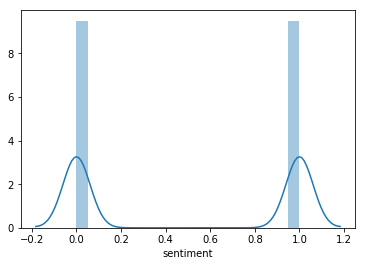

In [7]:
import seaborn as sns
sns.distplot(df.sentiment)

Wordcloud can demonstrate the most commonly used words



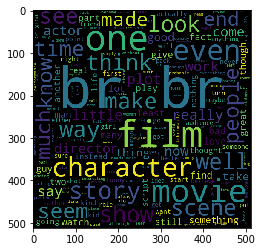

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
key_words0 = ' '.join(list(df[df.sentiment == 0]['review']))
kw0 = WordCloud(width = 512, height = 512).generate(key_words0)
plt.imshow(kw0)

br is actually from html <br> so that needs to be removed. 

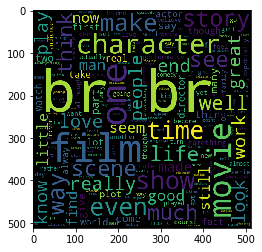

In [9]:
key_words1 = ' '.join(list(df[df.sentiment == 1]['review']))
kw1 = WordCloud(width = 512, height = 512).generate(key_words1)
plt.imshow(kw1)

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


process the raw text that may contain random symbols and "stopwords" that don't have meanings like "a" or "the"

In [0]:
import re

def process(text):
  text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  stemmer = SnowballStemmer('english')
  words = ""
  words = [stemmer.stem(w) for w in text]
  text = " ".join(words)
  text = re.sub('<(.*)>', '', text) ## (.*) is wildcard
  
  return text

Because the first half of the data is all 0 and the second half is 1, it's better to shuffle the data first before splitting it into train and test sets

In [12]:
shuffled_df = df.sample(frac = 1, random_state = 0)
print(shuffled_df.head())

                                                  review  sentiment
11841  After the success of the first two 'Godfather'...          1
19602  This film without doubt is one of the worst I ...          0
45519  Words fail me. This film was extremely difficu...          0
25747  I saw this movie when it first came out. It wa...          1
42642  I'm sure to people watching this move outside ...          0


In [0]:
reduced_df = shuffled_df[0:1000]

In [15]:
reduced_df['review'] = reduced_df['review'].apply(process)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer('english')
X = vectorizer.fit_transform(reduced_df.review).toarray()
X_train, X_test = X[:750], X[750:]
y_train, y_test = reduced_df.sentiment[:750], reduced_df.sentiment[750:]

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
print(clf.get_params().keys()) 

dict_keys(['priors', 'var_smoothing'])


In [0]:
import numpy as np
param_range = np.logspace(-15, -9, 7)
param_grid_Gau = [{'var_smoothing':param_range}]


In [0]:
gs = GridSearchCV(estimator = clf,
		 param_grid = param_grid_Gau,
		 scoring = 'accuracy',
		 cv = 5,
		 n_jobs = -1)
gs = gs.fit(X_train, y_train)

In [20]:
print(gs.best_params_)
print(gs.best_score_)

{'var_smoothing': 1e-12}
0.596


Naive Bayes trained with 1000 data did not yield good accuracy. Needs to try a different ML method or improve the learning with more data

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
KN = KNeighborsClassifier()
LR = LogisticRegression()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
SVC = SVC(probability = True)
CLFs = [('KN',KN),('LR',LR),('DT',DT),('RF',RF),('SVC',SVC)]
vc = VotingClassifier(estimators = CLFs, voting = 'hard')


In [30]:
import warnings
warnings.filterwarnings('ignore',category = FutureWarning)
clf_list = [KN,LR,DT,RF,SVC,vc]
accuracy= []

for clf in clf_list:
  clf.fit(X_train,y_train)
  accuracy.append(clf.score(X_train,y_train))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: Fu

In [39]:
[x for x in zip(clf_list,accuracy)]

[(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                       weights='uniform'), 0.824),
 (LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False), 0.9866666666666667),
 (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                         max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort=False,
                         random_state=None, splitter='best'), 1.0),
 (RandomForestCla

LogisticRegression, DecisionTree and RandomForest had very high accuracy score but could overfit the data. We can use the test set to see how well they perform on the test set.

In [41]:
test_accuracy= []
for clf in clf_list:
  clf.fit(X_train,y_train)
  test_accuracy.append(clf.score(X_train,y_train))

print([x for x in zip(clf_list,test_accuracy)])

[(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'), 0.824), (LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 0.9866666666666667), (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 1.0), (RandomForestClassifier(bootstrap=True, c

Turned out that LogisticRegression, DecisionTree and RandomForest still did well with the test set so they can actually make good prediction on new data.